<a href="https://colab.research.google.com/github/IsaacFigNewton/PMF-Classifier/blob/main/KNN_Estimation_of_Feature_Probability_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO

1.   Implement KNN with Dimensional K Neighbors:

  a. Modify the KNN algorithm to consider k nearest neighbors in each dimension.

  b. Ensure that the model accounts for a maximum of k * m neighbors, where m is the number of dimensions/features.

  c. Ensure that at least k neighbors are considered for estimating the value of x.

  d. Incorporate Inverse-Distance Kernel Weighting:


2.  Integrate an inverse-distance kernel weighting mechanism to improve accuracy.

  a. Ensure that the weight assigned to each neighbor is inversely proportional to its distance from the target point.


3.  Add Feature-Dependent Weighting:

  a. Develop a weighting scheme based on the percentage of variability in the class attributable to each feature.

  b. Adjust the influence of each feature in the final decision-making process according to its calculated weight.

  c. Test the impact of this feature-weighted approach on the overall model performance.



# Import Libraries and Config

In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
import json
import seaborn as sns
from itertools import permutations, product
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,\
                                      check_is_fitted,\
                                      check_array
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,\
                                      KBinsDiscretizer,\
                                      OneHotEncoder,\
                                      StandardScaler
from sklearn.neighbors import KernelDensity,\
                                      KNeighborsRegressor,\
                                      KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,\
                                      MultinomialNB
from sklearn.svm import SVC as SVM
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,\
                                      recall_score,\
                                      accuracy_score,\
                                      f1_score,\
                                      make_scorer
from sklearn.model_selection import KFold,\
                                      GridSearchCV,\
                                      cross_val_score,\
                                      cross_validate

In [2]:
# Prepare for k-fold cross-validation
default_n_neighbors = 1
max_bins_for_discretization = None
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
colormap = {
    0: 'red',
    1: 'green'
}
class_map = dict()

# Lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores = [], [], [], []

# Important Functions

## Probability Mass Function Estimator Class

In [3]:
class PMFRegressor(ClassifierMixin, BaseEstimator):

    def __init__(self, max_bins=None, alpha=1e-9, n_neighbors=1):
        # Max bins for discretization, to limit memory usage
        self.max_bins = max_bins
        # minimum weighted probability (0 implies that the feature of datapoints belonging to a class never takes on a given value)
        self.alpha = alpha
        #Number of neighbors to use in KNN estimation
        self.n_neighbors = n_neighbors
        self.classes_ = None
        self.X = None
        self.y = None
        self.prior_class_probabilities = None
        self.feature_distribution = None
        self.pmf_store = None


    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X = X
        self.y = y
        self.classes_ = np.unique(y)

        print("X:")
        print(X[:5])
        print("y:")
        print(y[:5])

        # Estimate the probability mass function
        self.prior_class_probabilities, self.feature_distribution, self.pmf_store = self.get_prob_distribution()

        # Return the classifier
        return self


    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        y = np.empty(X.shape[0], dtype=self.classes_.dtype)

        for i in range(X.shape[0]):
            datapoint = {j: X[i, j] for j in range(X.shape[1])}
            class_probabilities = self.calculate_class_probabilities(datapoint)
            predicted_class = max(class_probabilities, key=class_probabilities.get)
            y[i] = predicted_class

        return y



    # Main functions
    #*******************************************************************************************************************************************

    def get_prob_distribution(self):
        prior_class_probabilities = {class_value: self.get_prior_probability(class_value) for class_value in self.classes_}
        # create a multilevel dict to represent the weighted probabilities of every unique value of every feature for every class
        feature_distribution = {class_value: {feature: {} for feature in range(self.X.shape[1])} for class_value in self.classes_}
        # create a dict to hold the global probabilities of every unique value in every feature
        global_unique_val_probabilities = {feature: {} for feature in range(self.X.shape[1])}
        # create a dict to store PMFs for each feature and unique value
        pmf_store = {class_value: {feature: defaultdict() for feature in range(self.X.shape[1])} for class_value in self.classes_}


        # Calculating and storing PMFs
        for feature in range(self.X.shape[1]):
            # Get unique values for the current feature
            # default; discretize down to scale of datapoints
            unique_values = np.unique(self.X[:, feature])

            # alternate; discretize down to datapoints or max_bins
            if self.max_bins is not None and len(unique_values) > self.max_bins:
                 discretizer = KBinsDiscretizer(n_bins=self.max_bins, encode='ordinal', strategy='quantile')
                 unique_values = discretizer.fit_transform(unique_values.reshape(-1, 1)).flatten()


            # Calculate the weighted probability for each unique value
            for unique_value in unique_values:
                # Calculate the probability distribution for the current feature and unique value
                prob_distribution, p_unique = self.calculate_weighted_prob(unique_value, feature)

                # Add the weighted probabilities of the unique value to the feature distribution set
                for class_value in self.classes_:
                    feature_distribution[class_value][feature][unique_value] = prob_distribution[class_value]

                    # Create a KNN for the current feature
                    pmf = self.create_pmf_using_knn(class_value, feature, feature_distribution)

                    # Store the KNN for the current feature and class
                    pmf_store[class_value][feature] = pmf

                # Store the probability distribution for the current feature and unique value
                global_unique_val_probabilities[feature][unique_value] = p_unique

        return prior_class_probabilities, feature_distribution, pmf_store


    # Function to get prior probability of the class
    def get_prior_probability(self, class_value):
        return np.sum(self.y == class_value) / len(self.X)


    # Function to calculate probability distribution
    def calculate_weighted_prob(self, unique_value, feature):
        weighted_prob = {}

        # Calculate the probability of the unique value in the dataset as a whole
        mask = self.X[:, feature] == unique_value
        p_unique = np.sum(mask) / len(self.X)

        for class_value in self.classes_:
            # Filter the dataset for the current class and feature value
            class_mask = self.y == class_value
            class_data_mask = mask & class_mask

            p_unique_given_class = np.sum(class_data_mask) / np.sum(class_mask)

            # Avoid division by zero
            if p_unique > 0:
                weighted_prob[class_value] = p_unique_given_class / p_unique
            else:
                # No data for this unique value
                weighted_prob[class_value] = self.alpha

        return weighted_prob, p_unique


    # Function to create PMF using KNN
    def create_pmf_using_knn(self, class_value, feature, prob_distribution):
        # Get the values for the current feature and class
        values = np.array(list(prob_distribution[class_value][feature].keys())).reshape(-1, 1)
        # Get the weighted probabilities for the current feature and class
        probabilities = np.array(list(prob_distribution[class_value][feature].values()))

        # Create a kernel density estimator using Gaussian kernel
        knn = KNeighborsRegressor(n_neighbors=self.n_neighbors).fit(values, probabilities)

        return knn


    # Function to calculate P(class | feature1_value /\ feature2_value /\ …)
    def calculate_class_probabilities(self, feature_values):
        class_probabilities = {class_value: 1 for class_value in self.prior_class_probabilities.keys()}

        for class_value in self.prior_class_probabilities.keys():
            likelihood = 1
            for feature, value in feature_values.items():
                feature_likelihood = self.pmf_store[class_value][feature].predict(np.array([[value]]))
                # Accumulate features' weighted probabilities
                likelihood *= feature_likelihood

            # Get final class probability
            class_probability = likelihood * self.prior_class_probabilities[class_value]
            class_probabilities[class_value] = class_probability

        return class_probabilities



    # Helper functions
    #*******************************************************************************************************************************************

    # Map the features' weighted probability distributions to lists of features' values and their weighted probabilities
    def feature_distribution_to_dict(self):
        return {
            class_value: {
                feature: (list(self.feature_distribution[class_value][feature].keys()),
                          list(self.feature_distribution[class_value][feature].values()))
                for feature in range(self.X.shape[1])
            } for class_value in self.classes_
        }


    def print_weighted_prob_dist(self):
        print("Feature Distribution:")
        print(self.feature_distribution_to_dict())

## Utility

In [4]:
# Custom transformer to convert sparse matrix to dense
def to_dense(X):
    return np.array(X.todense()) if hasattr(X, 'todense') else X

dense_transformer = FunctionTransformer(to_dense)

In [5]:
def print_tree(tree, indent=0):
    # Iterate over the keys (features) in the tree
    for key, value in tree.items():
        print(' ' * indent + str(key))
        # If the value is a dictionary, recursively print the subtree
        if isinstance(value, dict):
            print_tree(value, indent + 4)
        else:
            print(' ' * (indent + 4) + str(value))

In [6]:
def cv_results_to_dict(pipeline, X, y):
    model_name = pipeline.steps[-1][0]

    # Perform cross-validation
    cv_results = cross_validate(pipeline,
                                X,
                                y,
                                cv=kf,
                                scoring=scoring,
                                return_train_score=False)

    # Calculate average scores and standard deviations
    avg_scores[model_name] = {
            "precision": cv_results['test_precision'].mean(),
            "recall": cv_results['test_recall'].mean(),
            "accuracy": cv_results['test_accuracy'].mean(),
            "f1": cv_results['test_f1'].mean(),
            "std_precision": cv_results['test_precision'].std(),
            "std_recall": cv_results['test_recall'].std(),
            "std_accuracy": cv_results['test_accuracy'].std(),
            "std_f1": cv_results['test_f1'].std(),
    }

    # Print average scores
    print("\nAverage Scores:")
    print(f"Precision: {avg_scores[model_name]['precision']:.4f} (+/- {avg_scores[model_name]['std_precision']:.4f})")
    print(f"Recall: {avg_scores[model_name]['recall']:.4f} (+/- {avg_scores[model_name]['std_recall']:.4f})")
    print(f"Accuracy: {avg_scores[model_name]['accuracy']:.4f} (+/- {avg_scores[model_name]['std_accuracy']:.4f})")
    print(f"F1 Score: {avg_scores[model_name]['f1']:.4f} (+/- {avg_scores[model_name]['std_f1']:.4f})")

    # If you want to see individual fold scores:
    for fold, (precision, recall, accuracy, f1) in enumerate(zip(
        cv_results['test_precision'],
        cv_results['test_recall'],
        cv_results['test_accuracy'],
        cv_results['test_f1']
    ), 1):
        print(f"\nFold {fold}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

# Import and Clean Dataset

In [7]:
# Load the dataset
# Titanic
dataset = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/titanic.csv")
dataset.drop(columns=["name", "ticketno"], inplace=True)
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

# take a sample for faster testing
dataset = dataset.loc[:500]
print(len(dataset))

# Identify categorical, continuous, and binary columns
quantitative_vars = ["age", "fare"]
categorical_vars = ["gender", "embarked", "class", "country"]
X = quantitative_vars + categorical_vars

y = ['survived']
class_map = {key: i for i, key in enumerate(dataset[y[0]].unique())}

dataset.head()

501


,gender,age,class,embarked,country,fare,survived
0,male,42.0,3rd,S,United States,7.11,0
1,male,13.0,3rd,S,United States,20.05,0
2,male,16.0,3rd,S,United States,20.05,0
3,female,39.0,3rd,S,England,20.05,1
4,female,16.0,3rd,S,Norway,7.13,1


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_vars),
        ('continuous', StandardScaler(), quantitative_vars)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', dense_transformer)
])

pipeline.fit(dataset[X])
transformed_feature_names = pipeline[:-1].get_feature_names_out()

# transform the dataset
transformed_dataset = pd.DataFrame(pipeline.transform(dataset[X]),
                                   columns=transformed_feature_names)
# add the y values back in, after resetting their indices
transformed_dataset[y[0]] = dataset[y[0]].reset_index(drop=True)
transformed_dataset.head()

,categorical__gender_female,categorical__gender_male,categorical__embarked_C,categorical__embarked_Q,categorical__embarked_S,categorical__class_1st,categorical__class_2nd,categorical__class_3rd,categorical__country_Argentina,categorical__country_Australia,...,categorical__country_South Africa,categorical__country_Spain,categorical__country_Sweden,categorical__country_Switzerland,categorical__country_United States,categorical__country_Uruguay,categorical__country_Wales,continuous__age,continuous__fare,survived
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.866454,-0.544214,0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.219640,-0.319763,0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.003837,-0.319763,0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650651,-0.319763,1
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.003837,-0.543867,1


In [9]:
transformed_dataset[transformed_dataset.isnull().any(axis=1)]

,categorical__gender_female,categorical__gender_male,categorical__embarked_C,categorical__embarked_Q,categorical__embarked_S,categorical__class_1st,categorical__class_2nd,categorical__class_3rd,categorical__country_Argentina,categorical__country_Australia,...,categorical__country_South Africa,categorical__country_Spain,categorical__country_Sweden,categorical__country_Switzerland,categorical__country_United States,categorical__country_Uruguay,categorical__country_Wales,continuous__age,continuous__fare,survived


In [10]:
len(transformed_dataset)

501

In [11]:
transformed_dataset.dropna(inplace=True)
len(transformed_dataset)

501

# Data Exploration

In [12]:
# # Parse the loose JSON representation into a dataframe

# # Initialize an empty list to store the rows
# rows = []

# # Iterate through the dictionary to extract the data
# for class_value, features in feature_distribution_x_y.items():
#     for feature, (x_values, y_values) in features.items():
#         # Create a DataFrame for the current feature
#         df_feature = pd.DataFrame({
#             'Class': class_value,
#             'Feature': feature,
#             'Feature Value': x_values,
#             'Weighted Probability': y_values
#         })
#         # Append the DataFrame to the rows list
#         rows.append(df_feature)

# # Concatenate all rows into a single DataFrame
# df = pd.concat(rows, ignore_index=True)

# df

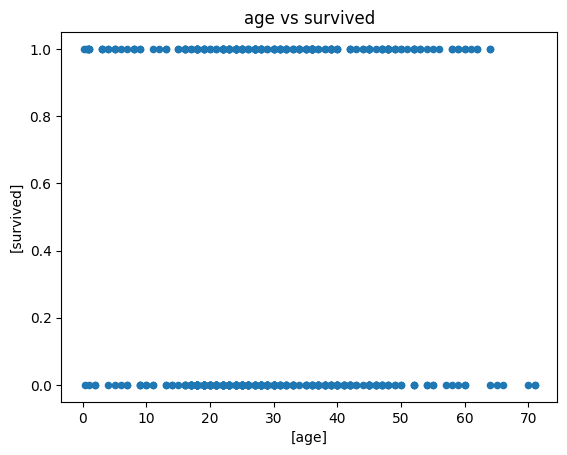

In [13]:
dataset.plot.scatter(x=[quantitative_vars[0]], y=y)
plt.title(f"{quantitative_vars[0]} vs {y[0]}")
plt.show()

# Cross Validation Against other Models

In [14]:
transformed_dataset.head()

,categorical__gender_female,categorical__gender_male,categorical__embarked_C,categorical__embarked_Q,categorical__embarked_S,categorical__class_1st,categorical__class_2nd,categorical__class_3rd,categorical__country_Argentina,categorical__country_Australia,...,categorical__country_South Africa,categorical__country_Spain,categorical__country_Sweden,categorical__country_Switzerland,categorical__country_United States,categorical__country_Uruguay,categorical__country_Wales,continuous__age,continuous__fare,survived
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.866454,-0.544214,0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.219640,-0.319763,0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.003837,-0.319763,0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650651,-0.319763,1
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.003837,-0.543867,1


In [15]:
# Define the scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

avg_scores = dict()

## Sklearn Classifiers


Average Scores:
Precision: 0.6797 (+/- 0.0551)
Recall: 0.7156 (+/- 0.0875)
Accuracy: 0.7406 (+/- 0.0553)
F1 Score: 0.6957 (+/- 0.0634)

Fold 1
Precision: 0.7209
Recall: 0.6596
Accuracy: 0.7228
F1 Score: 0.6889

Fold 2
Precision: 0.7317
Recall: 0.7500
Accuracy: 0.7900
F1 Score: 0.7407

Fold 3
Precision: 0.6585
Recall: 0.7500
Accuracy: 0.7700
F1 Score: 0.7013

Fold 4
Precision: 0.5814
Recall: 0.5814
Accuracy: 0.6400
F1 Score: 0.5814

Fold 5
Precision: 0.7059
Recall: 0.8372
Accuracy: 0.7800
F1 Score: 0.7660


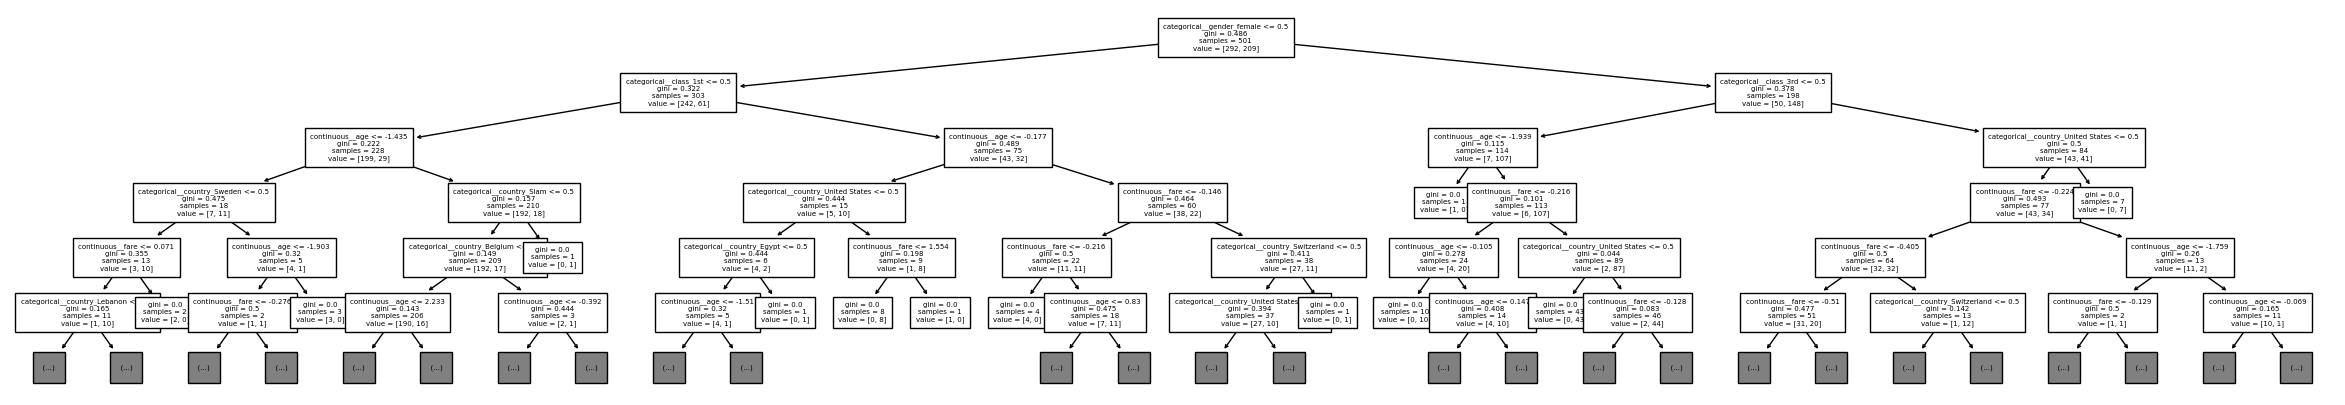

In [16]:
# Create a pipeline with preprocessor and DecisionTreeClassifier
pipeline = Pipeline([
    ('decision tree classifier', DecisionTreeClassifier())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])

# Fit the pipeline to the data
pipeline.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])

# Create a figure and axis with a wider x-axis
fig, ax = plt.subplots(figsize=(30, 5))

# Plot the decision tree
sk.tree.plot_tree(pipeline.named_steps['decision tree classifier'],
                  max_depth=5,
                  feature_names=transformed_feature_names,
                  fontsize=5,
                  ax=ax)

plt.show()

In [17]:
# Create a pipeline with preprocessor and KNeighborsClassifier
pipeline = Pipeline([
    ('knn classifier', KNeighborsClassifier(n_neighbors=default_n_neighbors))
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.6667 (+/- 0.0338)
Recall: 0.7244 (+/- 0.0318)
Accuracy: 0.7325 (+/- 0.0271)
F1 Score: 0.6931 (+/- 0.0144)

Fold 1
Precision: 0.7174
Recall: 0.7021
Accuracy: 0.7327
F1 Score: 0.7097

Fold 2
Precision: 0.6829
Recall: 0.7000
Accuracy: 0.7500
F1 Score: 0.6914

Fold 3
Precision: 0.6512
Recall: 0.7778
Accuracy: 0.7700
F1 Score: 0.7089

Fold 4
Precision: 0.6154
Recall: 0.7442
Accuracy: 0.6900
F1 Score: 0.6737

Fold 5
Precision: 0.6667
Recall: 0.6977
Accuracy: 0.7200
F1 Score: 0.6818


In [18]:
# Create a pipeline with preprocessor and GaussianNB classifier
pipeline = Pipeline([
    ('gaussian naive bayes classifier', GaussianNB())
])


cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.4327 (+/- 0.0413)
Recall: 0.9560 (+/- 0.0274)
Accuracy: 0.4590 (+/- 0.0440)
F1 Score: 0.5949 (+/- 0.0428)

Fold 1
Precision: 0.4947
Recall: 1.0000
Accuracy: 0.5248
F1 Score: 0.6620

Fold 2
Precision: 0.4286
Recall: 0.9750
Accuracy: 0.4700
F1 Score: 0.5954

Fold 3
Precision: 0.3656
Recall: 0.9444
Accuracy: 0.3900
F1 Score: 0.5271

Fold 4
Precision: 0.4301
Recall: 0.9302
Accuracy: 0.4400
F1 Score: 0.5882

Fold 5
Precision: 0.4444
Recall: 0.9302
Accuracy: 0.4700
F1 Score: 0.6015


In [19]:
# Create a pipeline with preprocessor and SVM classifier
pipeline = Pipeline([
    ('svm classifier', SVM())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.8320 (+/- 0.0864)
Recall: 0.6642 (+/- 0.0517)
Accuracy: 0.8004 (+/- 0.0337)
F1 Score: 0.7351 (+/- 0.0370)

Fold 1
Precision: 1.0000
Recall: 0.6170
Accuracy: 0.8218
F1 Score: 0.7632

Fold 2
Precision: 0.7714
Recall: 0.6750
Accuracy: 0.7900
F1 Score: 0.7200

Fold 3
Precision: 0.8182
Recall: 0.7500
Accuracy: 0.8500
F1 Score: 0.7826

Fold 4
Precision: 0.7647
Recall: 0.6047
Accuracy: 0.7500
F1 Score: 0.6753

Fold 5
Precision: 0.8056
Recall: 0.6744
Accuracy: 0.7900
F1 Score: 0.7342


In [20]:
# Create a pipeline with preprocessor and MLP classifier
pipeline = Pipeline([
    ('mlp classifier', MLP())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Average Scores:
Precision: 0.8072 (+/- 0.0923)
Recall: 0.6656 (+/- 0.0950)
Accuracy: 0.7904 (+/- 0.0480)
F1 Score: 0.7236 (+/- 0.0673)

Fold 1
Precision: 0.9677
Recall: 0.6383
Accuracy: 0.8218
F1 Score: 0.7692

Fold 2
Precision: 0.6923
Recall: 0.6750
Accuracy: 0.7500
F1 Score: 0.6835

Fold 3
Precision: 0.7838
Recall: 0.8056
Accuracy: 0.8500
F1 Score: 0.7945

Fold 4
Precision: 0.7586
Recall: 0.5116
Accuracy: 0.7200
F1 Score: 0.6111

Fold 5
Precision: 0.8333
Recall: 0.6977
Accuracy: 0.8100
F1 Score: 0.7595


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
# Create a pipeline with preprocessor and RandomForestClassifier classifier
pipeline = Pipeline([
    ('rf classifier', RandomForestClassifier())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.7538 (+/- 0.0645)
Recall: 0.7463 (+/- 0.0550)
Accuracy: 0.7884 (+/- 0.0319)
F1 Score: 0.7464 (+/- 0.0278)

Fold 1
Precision: 0.8611
Recall: 0.6596
Accuracy: 0.7921
F1 Score: 0.7470

Fold 2
Precision: 0.6818
Recall: 0.7500
Accuracy: 0.7600
F1 Score: 0.7143

Fold 3
Precision: 0.7500
Recall: 0.8333
Accuracy: 0.8400
F1 Score: 0.7895

Fold 4
Precision: 0.6957
Recall: 0.7442
Accuracy: 0.7500
F1 Score: 0.7191

Fold 5
Precision: 0.7805
Recall: 0.7442
Accuracy: 0.8000
F1 Score: 0.7619


## Custom Approach

In [22]:
# Define the parameter grid
param_grid = {
    'regressor__n_neighbors': range(1, 5)
}

# Create a scorer dictionary
scorers = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

pipeline = Pipeline([
    ("regressor", PMFRegressor(max_bins_for_discretization))
])

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,  # Use the same KFold object as before
    scoring=scorers,
    refit='f1',  # Refit using the best F1 score
    return_train_score=False,
    n_jobs=-1  # Use all available cores
)

# Fit the GridSearchCV object
grid_search.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]].map(class_map))

# Get the results
results = pd.DataFrame(grid_search.cv_results_)

# Process the results
avg_scores["custom"] = dict()
f1_by_k = {}

for i, row in results.iterrows():
    k = row['param_regressor__n_neighbors']
    avg_scores["custom"][k] = {
        "precision": row['mean_test_precision'],
        "recall": row['mean_test_recall'],
        "accuracy": row['mean_test_accuracy'],
        "f1": row['mean_test_f1'],
        "std_precision": row['std_test_precision'],
        "std_recall": row['std_test_recall'],
        "std_accuracy": row['std_test_accuracy'],
        "std_f1": row['std_test_f1']
    }
    f1_by_k[k] = row['mean_test_f1']

# Convert f1_by_k to DataFrame
f1_by_k = pd.DataFrame(f1_by_k.items(), columns=["k", "f1"])

# Get the best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

# You can now use the best model for predictions
best_model = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.7008457       nan       nan       nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.70055446        nan        nan        nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.69823295        nan        nan        nan]
  warnings.warn(


X:
[[ 0.          1.          0.          0.          1.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.86645362 -0.54421372]
 [ 0.          1.          0.          0.          1.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.         -1.21963981 -0.31976294]
 [ 0.          1.          0.          0.          1.          0.
   0.          1.          0.        

### Results

In [23]:
print(f1_by_k.head())

   k        f1
0  1  0.698233
1  2       NaN
2  3       NaN
3  4       NaN


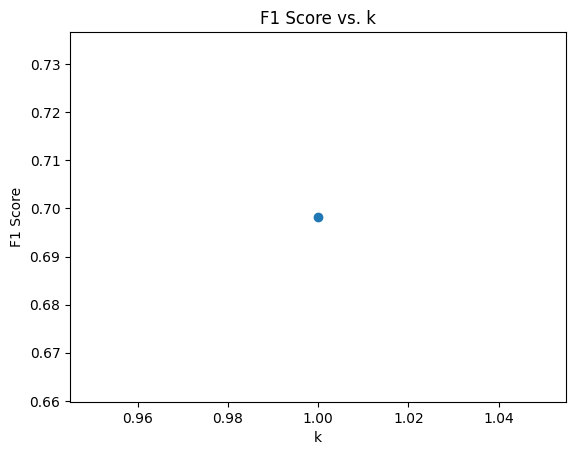

In [24]:
plt.plot(f1_by_k["k"], f1_by_k["f1"], marker='o') # Use plt.plot() for line plots
plt.title("F1 Score vs. k")
plt.xlabel("k")
plt.ylabel("F1 Score")
plt.show()

In [25]:
optimal_k = grid_search.best_params_['regressor__n_neighbors']

print(f"Optimal k: {optimal_k}")

Optimal k: 1


In [26]:
# Print average scores
print()
print("Average Scores for Optimal k:")
print(f"n_neighbors = {optimal_k}")
print(f"Precision: {avg_scores['custom'][optimal_k]['precision']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_precision']:.4f})")
print(f"Recall: {avg_scores['custom'][optimal_k]['recall']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_recall']:.4f})")
print(f"Accuracy: {avg_scores['custom'][optimal_k]['accuracy']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_accuracy']:.4f})")
print(f"F1 Score: {avg_scores['custom'][optimal_k]['f1']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_f1']:.4f})")


Average Scores for Optimal k:
n_neighbors = 1
Precision: 0.7008 (+/- 0.0495)
Recall: 0.7006 (+/- 0.0480)
Accuracy: 0.7006 (+/- 0.0480)
F1 Score: 0.6982 (+/- 0.0479)


In [27]:
model = best_model.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]].map(class_map))
y_pred = pd.Series(model.predict(transformed_dataset[transformed_feature_names]))

X:
[[ 0.          1.          0.          0.          1.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.86645362 -0.54421372]
 [ 0.          1.          0.          0.          1.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.         -1.21963981 -0.31976294]
 [ 0.          1.          0.          0.          1.          0.
   0.          1.          0.        

In [28]:
transformed_feature_names

array(['categorical__gender_female', 'categorical__gender_male',
       'categorical__embarked_C', 'categorical__embarked_Q',
       'categorical__embarked_S', 'categorical__class_1st',
       'categorical__class_2nd', 'categorical__class_3rd',
       'categorical__country_Argentina', 'categorical__country_Australia',
       'categorical__country_Belgium', 'categorical__country_Bosnia',
       'categorical__country_Bulgaria', 'categorical__country_Canada',
       'categorical__country_Channel Islands',
       'categorical__country_Croatia (Modern)',
       'categorical__country_Denmark', 'categorical__country_Egypt',
       'categorical__country_England', 'categorical__country_Finland',
       'categorical__country_France', 'categorical__country_Hungary',
       'categorical__country_India', 'categorical__country_Ireland',
       'categorical__country_Italy', 'categorical__country_Lebanon',
       'categorical__country_Norway', 'categorical__country_Peru',
       'categorical__country_

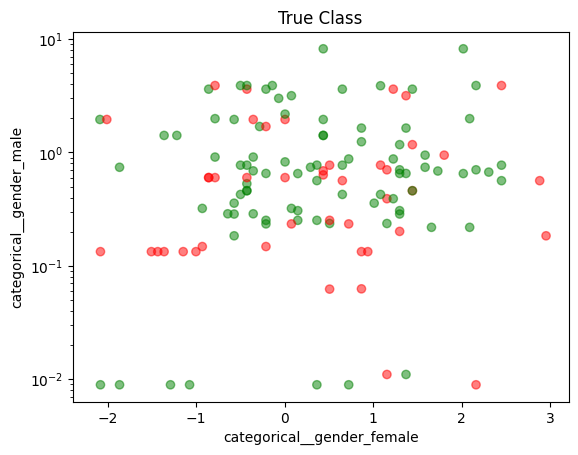

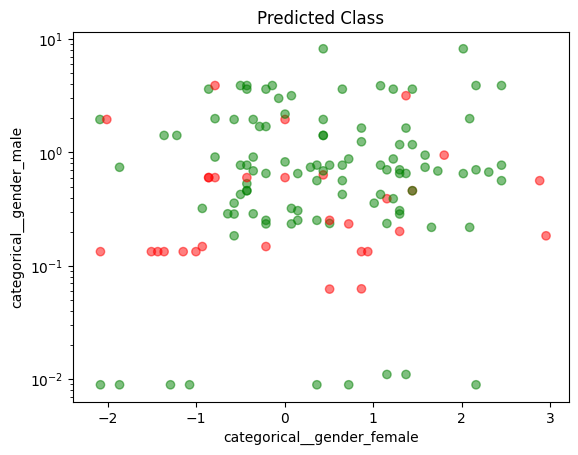

In [29]:
if len(quantitative_vars) > 1:
  plt.scatter(transformed_dataset["continuous__" + quantitative_vars[0]],\
              transformed_dataset["continuous__" + quantitative_vars[1]],\
              c=transformed_dataset[y[0]].map(colormap),\
              alpha=0.5)

  # Add labels and title
  plt.title("True Class")
  plt.xlabel(transformed_feature_names[0])
  plt.ylabel(transformed_feature_names[1])
  plt.yscale('log')
  plt.show()

  plt.scatter(transformed_dataset["continuous__" + quantitative_vars[0]],\
              transformed_dataset["continuous__" + quantitative_vars[1]],\
              c=y_pred.map(colormap),\
              alpha=0.5)

  # Add labels and title
  plt.title("Predicted Class")
  plt.xlabel(transformed_feature_names[0])
  plt.ylabel(transformed_feature_names[1])
  plt.yscale('log')
  plt.show()

# Compare Models

In [30]:
for model_name, scores in avg_scores.items():
      if model_name != "custom":
          print(f"{model_name}:")
          print(f"Precision: {scores['precision']:.4f} (+/- {scores['std_precision']:.4f})")
          print(f"Recall: {scores['recall']:.4f} (+/- {scores['std_recall']:.4f})")
          print(f"Accuracy: {scores['accuracy']:.4f} (+/- {scores['std_accuracy']:.4f})")
          print(f"F1 Score: {scores['f1']:.4f} (+/- {scores['std_f1']:.4f})")
          print()
      else:
          print(f"{model_name}:")
          print(f"Optimal n_neighbors = {optimal_k}")
          print(f"Precision: {avg_scores['custom'][optimal_k]['precision']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_precision']:.4f})")
          print(f"Recall: {avg_scores['custom'][optimal_k]['recall']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_recall']:.4f})")
          print(f"Accuracy: {avg_scores['custom'][optimal_k]['accuracy']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_accuracy']:.4f})")
          print(f"F1 Score: {avg_scores['custom'][optimal_k]['f1']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_f1']:.4f})")
          print()

decision tree classifier:
Precision: 0.6797 (+/- 0.0551)
Recall: 0.7156 (+/- 0.0875)
Accuracy: 0.7406 (+/- 0.0553)
F1 Score: 0.6957 (+/- 0.0634)

knn classifier:
Precision: 0.6667 (+/- 0.0338)
Recall: 0.7244 (+/- 0.0318)
Accuracy: 0.7325 (+/- 0.0271)
F1 Score: 0.6931 (+/- 0.0144)

gaussian naive bayes classifier:
Precision: 0.4327 (+/- 0.0413)
Recall: 0.9560 (+/- 0.0274)
Accuracy: 0.4590 (+/- 0.0440)
F1 Score: 0.5949 (+/- 0.0428)

svm classifier:
Precision: 0.8320 (+/- 0.0864)
Recall: 0.6642 (+/- 0.0517)
Accuracy: 0.8004 (+/- 0.0337)
F1 Score: 0.7351 (+/- 0.0370)

mlp classifier:
Precision: 0.8072 (+/- 0.0923)
Recall: 0.6656 (+/- 0.0950)
Accuracy: 0.7904 (+/- 0.0480)
F1 Score: 0.7236 (+/- 0.0673)

rf classifier:
Precision: 0.7538 (+/- 0.0645)
Recall: 0.7463 (+/- 0.0550)
Accuracy: 0.7884 (+/- 0.0319)
F1 Score: 0.7464 (+/- 0.0278)

custom:
Optimal n_neighbors = 1
Precision: 0.7008 (+/- 0.0495)
Recall: 0.7006 (+/- 0.0480)
Accuracy: 0.7006 (+/- 0.0480)
F1 Score: 0.6982 (+/- 0.0479)



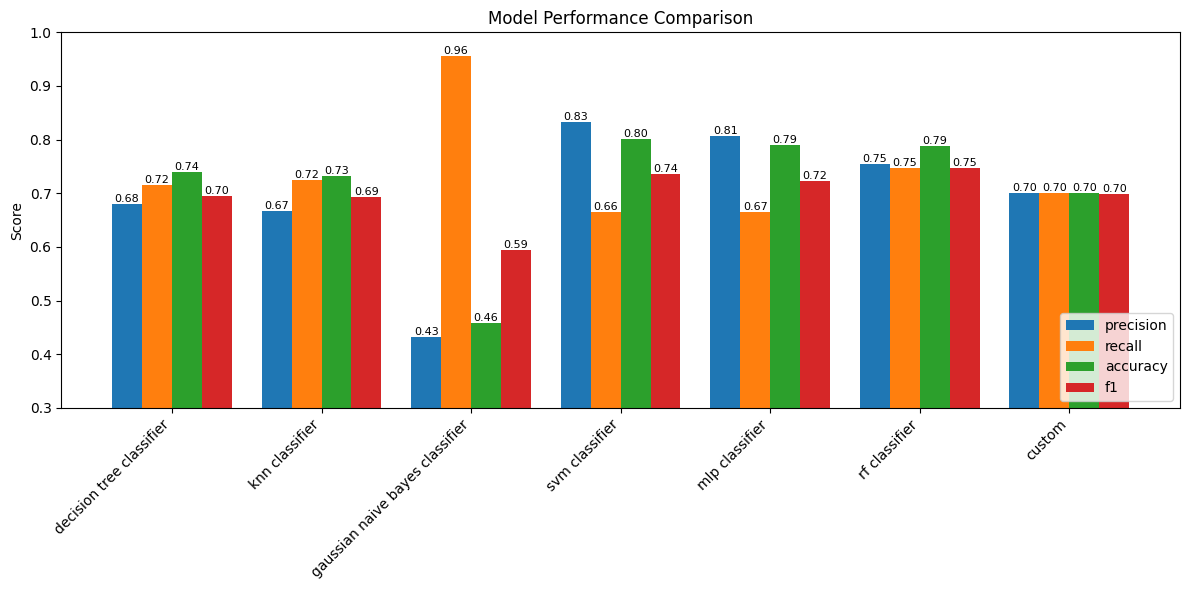

In [31]:
# Prepare data for plotting
models = list(avg_scores.keys())
metrics = ['precision', 'recall', 'accuracy', 'f1']
x = np.arange(len(models))
width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(avg_scores[model][optimal_k][metric])
        else:
            values.append(avg_scores[model][metric])
    ax.bar(x + i*width, values, width, label=metric)

# Customize the plot
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0.3, 1)

# Add value labels on top of each bar
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(avg_scores[model][optimal_k][metric])
        else:
            values.append(avg_scores[model][metric])
    for j, v in enumerate(values):
        ax.text(j + i*width, v, f'{v:.2f}', ha='center', va='bottom', rotation=0, fontsize=8)

plt.tight_layout()
plt.show()